# Joint cascade model (energy only)

Same as `2d_effective_area` but separating out the energy dependence in order to debug the sensitivity to $\alpha$.

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import stan_utility
import corner
from joint_model_cascades import * 

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
random_seed = 19920715

## Forward model

In [3]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
    
# Select sources within redshift zth to mimic catalogue
zth = 1
selection = np.where(redshift < zth)[0]

In [4]:
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])

# Try ordering sources by redshift, as larger z => lower F
# This could help eliminate degeneracies in the mixture
inds = redshift.argsort()[::-1]
redshift = redshift[inds]
position = position[inds]
unit_vector = [p / np.linalg.norm(p) for p in position]

# Add background redshift
redshift = list(redshift) + [zth]

In [5]:
# Use simple Aeff calculated in `spline_dev/clean_spline_snippet.ipynb`
# Define spline 
p = 3 # spline degree
xknots = np.array([2.90998783, 4.03010253, 5.00991847, 6.96995941]) # knot sequence
yknots = np.array([-0.9,  0.1,  0.9]) # knot sequence
Nx = len(xknots)+p-1 # number of coefficients that need to be defined
Ny = len(yknots)+p-1 # number of coefficients that need to be defined
N = Nx * Ny

# Coefficients
c = np.asarray(
    [-3.58077707, -3.41361407, -3.67857551, -4.18870088, -4.33580191, -1.96090326,
     -1.97689,    -2.05099873, -2.14549395, -2.17675871, -0.34077015, -0.32737177,
     -0.30599357, -0.29709922, -0.29278352,  0.48041494,  0.94140028,  1.02319478,
     0.88547053,  0.95448815, -0.26299716,  0.99602738,  1.47548988,  1.31308221,
     1.42759428, -1.33184261,  0.47994404,  1.74747881,  1.44319947,  1.39107924])
c = c.reshape(Nx, Ny)

In [6]:
# Get precomputed eps factor
with h5py.File('precomputed_eps_test.h5', 'r') as f:
    alpha_grid = f['alpha_grid'].value
    eps = f['eps'].value

In [7]:
with h5py.File('../data/Aeff_shape.h5', 'r') as f:
    log10Aeff = f['log10Aeff'].value

In [8]:
print('Max Aeff: ', np.max(10**log10Aeff))
Aeff_max = 31 # m^2 

Max Aeff:  30.300822794250863


## Simulation

In [55]:
# Prepare simulation inputs
sim_input = {}

# Sources
sim_input['Ns'] = Ns
sim_input['z'] = redshift
dl = [luminosity_distance(z) for z in redshift[:-1]] # Mpc
sim_input['D'] = dl # Mpc
sim_input['varpi'] = unit_vector

# Energies
sim_input['alpha'] = 2.0
sim_input['Emin'] = 1.0e4 # GeV ie. 10 TeV
sim_input['f_E'] = 0.2 # 0.2

# Associated fraction 
total_flux = 1e2 # m^-2 yr^-1
f = 0.5

Q = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*Mpc_to_m)**2) for d in dl])) ) # yr^-1
F0 = (1 - f) * total_flux # m^-2 yr^-1

sim_input['Q'] = Q # yr^-1
sim_input['F0'] = F0 # m^-2 yr^-1

# Exposure
sim_input['Ngrid'] = len(alpha_grid)
sim_input['alpha_grid'] = alpha_grid
sim_input['eps_grid'] = eps
sim_input['T'] = 1

# Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c

print('Q: ', Q)
print('F0: ', F0)

Q:  2.9712629768847614e+53
F0:  50.0


In [56]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/joint_cascade_sim_energy_only.stan', 
                                 model_name = 'energy_only_sim', 
                                 include_paths = 'stan/')

Using cached StanModel


In [57]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed=random_seed)

In [58]:
# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet = simulation.extract(['Edet'])['Edet'][0]

In [59]:
# Labels
lam = simulation.extract(['lambda'])['lambda'][0] - 1
Nc = Ns
label_cmap = plt.cm.get_cmap('plasma', Nc+1)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)

Nsrc:  23
Nbg:  29


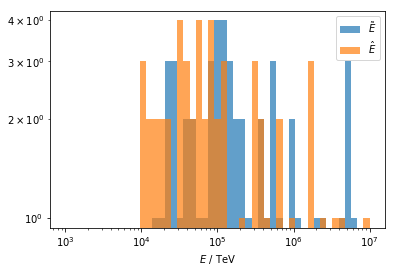

In [60]:
# Plot energies
Emin = sim_input['Emin']
bins = np.logspace(np.log(Emin/10), np.log(1E+3 * Emin), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins = bins, label = '$\\tilde{E}$', alpha = 0.7);
#ax.hist(E, bins = bins, label = '$E$', alpha = 0.7);
ax.hist(Edet, bins = bins, label = '$\hat{E}$', alpha = 0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / TeV')
ax.legend();

## Fit

In [61]:
# Compile the model
model = stan_utility.compile_model(filename='stan/joint_cascade_model_energy_only.stan', 
                                   model_name = 'energy_only_model', 
                                   include_paths = 'stan/')

Using cached StanModel


In [62]:
# Prepare fit inputs
fit_input = {}
fit_input['N'] = len(Edet)
fit_input['Emin'] = sim_input['Emin']
fit_input['f_E'] = sim_input['f_E']
fit_input['Edet'] = Edet
fit_input['Ns'] = sim_input['Ns']
fit_input['varpi'] = sim_input['varpi']
fit_input['D'] = sim_input['D']
fit_input['z'] = sim_input['z']
fit_input['Ngrid'] = sim_input['Ngrid'] 
fit_input['alpha_grid'] = sim_input['alpha_grid'] 
fit_input['eps_grid'] = sim_input['eps_grid'] 
fit_input['T'] = sim_input['T']

# Spline
fit_input['p'] = sim_input['p']
fit_input['Lknots_x'] = sim_input['Lknots_x'] 
fit_input['Lknots_y'] = sim_input['Lknots_y'] 
fit_input['xknots'] = sim_input['xknots'] 
fit_input['yknots'] = sim_input['yknots'] 
fit_input['c'] = sim_input['c'] 

# Debugging
fit_input['alpha_true'] = sim_input['alpha']
fit_input['Q_scale'] = sim_input['Q']
fit_input['F0_scale'] = sim_input['F0']

In [63]:
fit = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = random_seed)

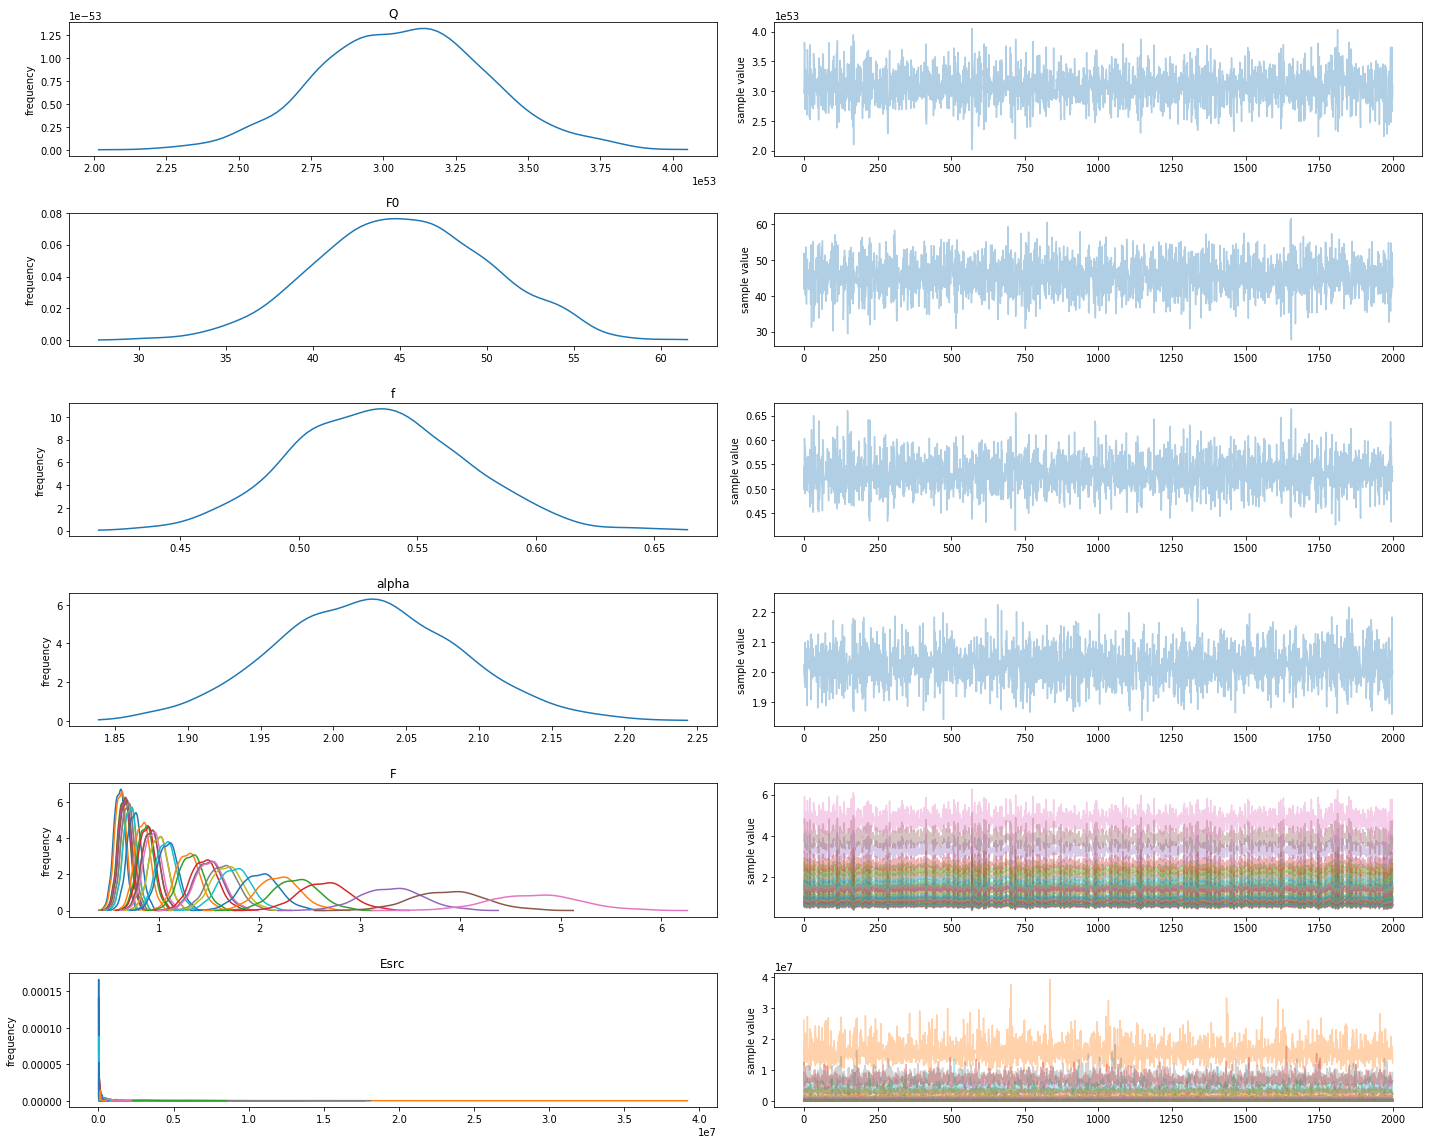

In [64]:
fig = fit.plot([r'Q', r'F0', r'f', r'alpha', r'F', r'Esrc']);
fig.set_size_inches(20, 16)
fig.tight_layout()

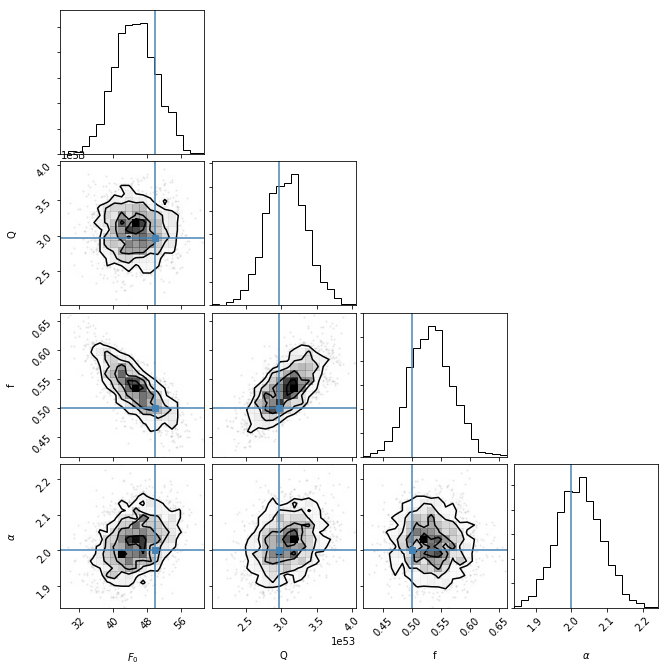

In [65]:
chain = fit.extract(permuted = True)
key_list = ['F0', 'Q', 'f', 'alpha']
labels = [r'$F_0$', r'Q', 'f', r'$\alpha$']
truths = [F0 , Q, f, sim_input['alpha']]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);